# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader


# Download Dataset

In [2]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.82G/1.83G [00:25<00:00, 55.5MB/s]
100% 1.83G/1.83G [00:25<00:00, 76.0MB/s]


In [ ]:
# !gdown --id 1-8UrAsreTpYezl2z58xdg8v6ab2BbYmu

In [4]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create Generator

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])
BATCH_SIZE=32
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 


In [ ]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [ ]:
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.4839),
 tensor(0.),
 tensor(1.))

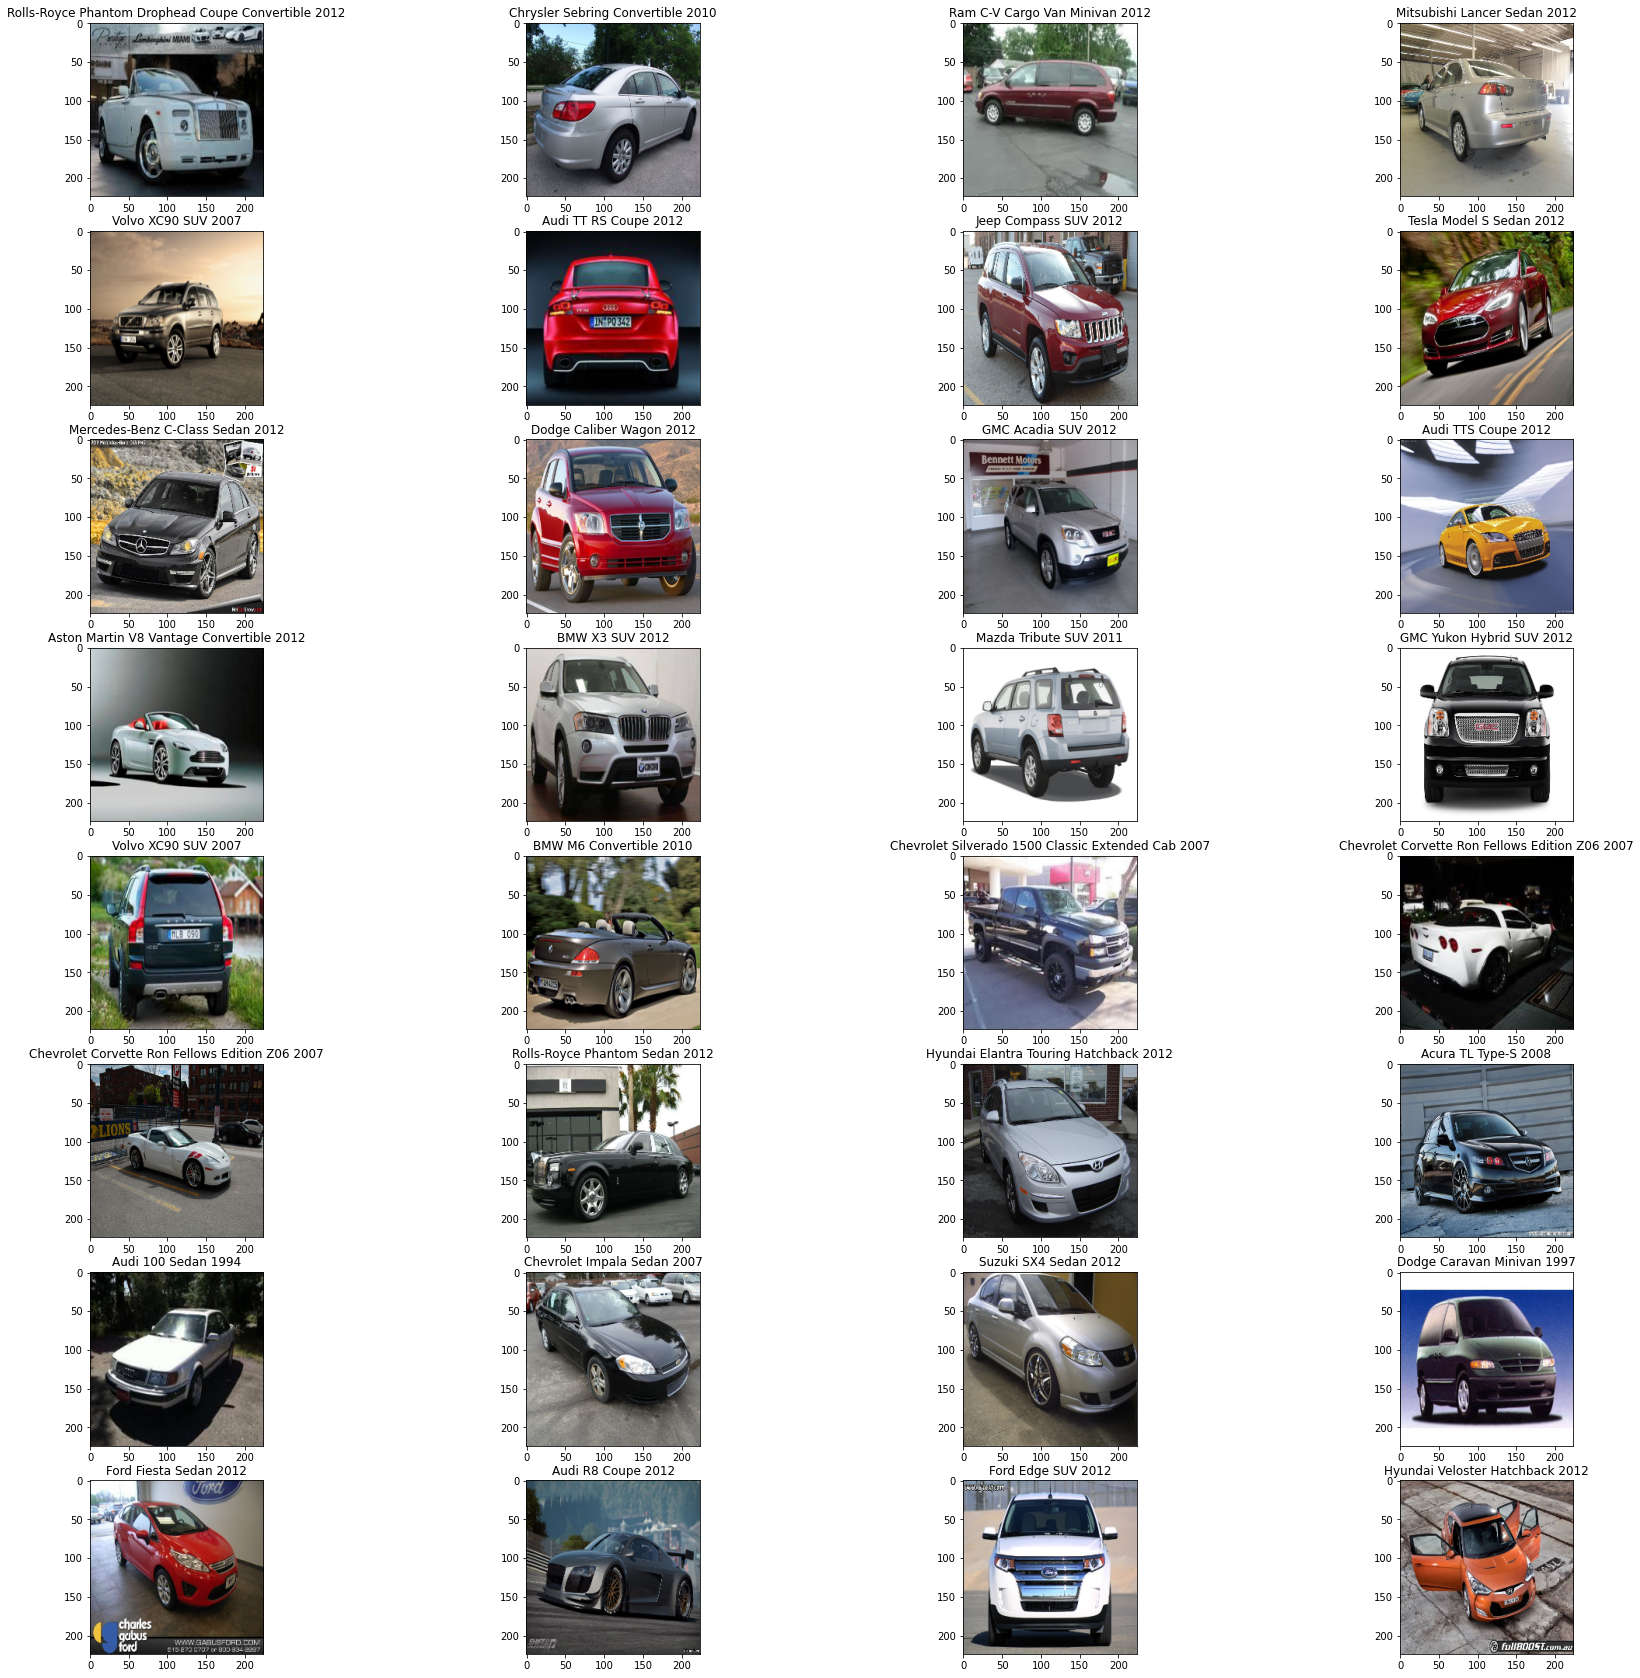

In [6]:
import numpy as np

classes = list(train_data.class_to_idx)


test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [7]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            data_size=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    preds = (outputs > 0.5).float ()
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                data_size+=len(outputs)

                current_loss += loss.item() * inputs.size(0)
#                 preds = torch.argmax(preds, dim=-1)
                preds = torch.argmax(outputs, dim=-1)
                current_corrects += torch.sum(preds == labels.data)            


            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / data_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
dataset_sizes

{'train': 255, 'val': 252}

In [8]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

res_mod = models.resnet50(pretrained=True)
model = ResnetModel(res_mod, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

pytorch_total_params=  24657668
pytorch_total_trainable_params=  24657668


In [ ]:
model

ResnetModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss() 

In [ ]:
model = model.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)


Epoch 0/1
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 167.6017 Acc: 0.0053
Iterating through data...
val Loss: 164.8556 Acc: 0.0085

Epoch 1/1
----------
Iterating through data...
train Loss: 165.1570 Acc: 0.0068
Iterating through data...
val Loss: 164.8829 Acc: 0.0057

Training complete in 10m 16s
Best val Acc: 0.008457


In [ ]:
####################################################

# Q1

In [ ]:
# Q1
# resnet model with random initialization
res_mod1 = models.resnet50(pretrained=False)
model1 = ResnetModel(res_mod1, num_classes=len(classes))
pytorch_total_params1 = sum(p.numel() for p in model1.parameters())
pytorch_total_trainable_params1 = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print('first model, pytorch_total_params= ', pytorch_total_params1 )
print('first model, pytorch_total_trainable_params= ', pytorch_total_trainable_params1)

first model, pytorch_total_params=  24657668
first model, pytorch_total_trainable_params=  24657668


In [ ]:
model1 = model1.to(device)

# Observe that all parameters are being optimized
optimizer_ft1 = optim.Adam(model1.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler1 = lr_scheduler.StepLR(optimizer_ft1, step_size=7, gamma=0.1)
base_model1 = train_model(model1, criterion, optimizer_ft1, exp_lr_scheduler1, num_epochs=25)

Epoch 0/24
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 171.0293 Acc: 0.0074
Iterating through data...
val Loss: 166.1106 Acc: 0.0078

Epoch 1/24
----------
Iterating through data...
train Loss: 166.5294 Acc: 0.0079
Iterating through data...
val Loss: 165.6616 Acc: 0.0080

Epoch 2/24
----------
Iterating through data...
train Loss: 165.5120 Acc: 0.0098
Iterating through data...
val Loss: 164.9494 Acc: 0.0121

Epoch 3/24
----------
Iterating through data...
train Loss: 164.7436 Acc: 0.0131
Iterating through data...
val Loss: 164.9843 Acc: 0.0108

Epoch 4/24
----------
Iterating through data...
train Loss: 163.5543 Acc: 0.0122
Iterating through data...
val Loss: 164.5016 Acc: 0.0160

Epoch 5/24
----------
Iterating through data...
train Loss: 161.7358 Acc: 0.0157
Iterating through data...
val Loss: 168.1694 Acc: 0.0133

Epoch 6/24
----------
Iterating through data...
train Loss: 157.7495 Acc: 0.0222
Iterating through data...
val Loss: 157.7396 Acc: 0.0285

Epoch 7/24
----------
Iterating through data...
train Loss: 155.7243 Acc: 0

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Q2

In [11]:
model2_save_name = 'model2.pth'
path2 = F"/content/gdrive/My Drive/{model2_save_name}" 

In [ ]:
# Q2
# pretrained resnet model (freezed resnet parameters)
res_mod2 = models.resnet50(pretrained=True)
for param in res_mod2.parameters():
    param.requires_grad = False
    
model2 = ResnetModel(res_mod2, num_classes=len(classes))
pytorch_total_params2 = sum(p.numel() for p in model2.parameters())
pytorch_total_trainable_params2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print('second model, pytorch_total_params= ', pytorch_total_params2)
print('second model, pytorch_total_trainable_params= ', pytorch_total_trainable_params2)

second model, pytorch_total_params=  24657668
second model, pytorch_total_trainable_params=  1149636


In [ ]:
model2 = model2.to(device)

# Observe that all parameters are being optimized
optimizer_ft2 = optim.Adam(model2.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer_ft2, step_size=7, gamma=0.1)
base_model2 = train_model(model2, criterion, optimizer_ft2, exp_lr_scheduler2, num_epochs=15)

Epoch 0/14
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 142.7363 Acc: 0.0891
Iterating through data...
val Loss: 112.2689 Acc: 0.1916

Epoch 1/14
----------
Iterating through data...
train Loss: 95.8416 Acc: 0.2839
Iterating through data...
val Loss: 102.6382 Acc: 0.2527

Epoch 2/14
----------
Iterating through data...
train Loss: 78.7650 Acc: 0.3886
Iterating through data...
val Loss: 101.3671 Acc: 0.2874

Epoch 3/14
----------
Iterating through data...
train Loss: 67.8342 Acc: 0.4522
Iterating through data...
val Loss: 96.6486 Acc: 0.3109

Epoch 4/14
----------
Iterating through data...
train Loss: 59.9808 Acc: 0.5027
Iterating through data...
val Loss: 98.0564 Acc: 0.3207

Epoch 5/14
----------
Iterating through data...
train Loss: 55.5722 Acc: 0.5427
Iterating through data...
val Loss: 100.1700 Acc: 0.3366

Epoch 6/14
----------
Iterating through data...
train Loss: 28.0796 Acc: 0.7677
Iterating through data...
val Loss: 81.7615 Acc: 0.4007

Epoch 7/14
----------
Iterating through data...
train Loss: 25.0937 Acc: 0.7990
Iter

In [ ]:
torch.save(model2.state_dict(), path2)

In [13]:
state_dict2 = torch.load(path2)

In [14]:
res_mod2 = models.resnet50()
model2 = ResnetModel(res_mod2, num_classes=len(classes))
model2.load_state_dict(state_dict2)

<All keys matched successfully>

# Q3

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        return f

In [ ]:
def extract(model, phase):
    features = []
    true_labels = []
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        out = model(inputs)
        
        for i in range(out.cpu().shape[0]):
            features.append(np.array(out[i].cpu()))
            true_labels.append(labels[i].cpu())
            
    return (features, true_labels)

In [ ]:
# Q3
# pretrained resnet model (freezed resnet parameters)
# with SVM classifier
res_mod3 = models.resnet50(pretrained=True)
for param in res_mod3.parameters():
    param.requires_grad = False
    
model3 = FeatureExtractor(res_mod3)
model3 = model3.to(device)

features, labels = extract(model3, 'train')
features_val, labels_val = extract(model3, 'val')

In [ ]:
features = np.array(features)
labels = np.array([x for x in labels])  # convert tensor to number

features_val = np.array(features_val)
labels_val = np.array([x for x in labels_val])

print(features.shape)
print(labels.shape)
print(features_val.shape)
print(labels_val.shape)

(8144, 2048)
(8144,)
(8041, 2048)
(8041,)


In [ ]:
from sklearn import svm

#Create a svm Classifier
svm_classifier = svm.SVC(kernel='rbf') 

#Train the model using the training sets
svm_classifier.fit(features, labels)

SVC()

In [ ]:
from sklearn import metrics

y_pred = svm_classifier.predict(features)
print("Accuracy on train data:", metrics.accuracy_score(labels, y_pred))

Accuracy on train data: 0.9680746561886051


In [ ]:
y_pred_val = svm_classifier.predict(features_val)
print("Accuracy:", metrics.accuracy_score(labels_val, y_pred_val))

Accuracy: 0.3283173734610123


# Q4

In [ ]:
# Q4
# pretrained resnet model (train last layers of resnet)

# first load model2, then defreeze some layers
res_mod4 = models.resnet50()
model4 = ResnetModel(res_mod4, num_classes=len(classes))
model4.load_state_dict(state_dict2)

layer = 0
for name, module in model4.features.named_modules():
    if layer > 130:
        for p in module.parameters():
            p.requires_grad = False
    layer += 1


In [12]:
model4_save_name = 'model4.pth'
path4 = F"/content/gdrive/MyDrive/{model4_save_name}" 

In [ ]:
model4 = model4.to(device)

# Observe that all parameters are being optimized
optimizer_ft4 = optim.Adam(model4.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler4 = lr_scheduler.StepLR(optimizer_ft4, step_size=7, gamma=0.1)
base_model4 = train_model(model4, criterion, optimizer_ft4, exp_lr_scheduler4, num_epochs=20)

Epoch 0/19
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 117.3744 Acc: 0.2247
Iterating through data...
val Loss: 115.9895 Acc: 0.2450

Epoch 1/19
----------
Iterating through data...
train Loss: 63.1230 Acc: 0.4908
Iterating through data...
val Loss: 101.2994 Acc: 0.3343

Epoch 2/19
----------
Iterating through data...
train Loss: 43.6726 Acc: 0.6195
Iterating through data...
val Loss: 115.3291 Acc: 0.3429

Epoch 3/19
----------
Iterating through data...
train Loss: 32.4912 Acc: 0.7074
Iterating through data...
val Loss: 92.4003 Acc: 0.4053

Epoch 4/19
----------
Iterating through data...
train Loss: 27.8112 Acc: 0.7570
Iterating through data...
val Loss: 91.4190 Acc: 0.4196

Epoch 5/19
----------
Iterating through data...
train Loss: 24.3971 Acc: 0.7750
Iterating through data...
val Loss: 102.7625 Acc: 0.4119

Epoch 6/19
----------
Iterating through data...
train Loss: 6.4679 Acc: 0.9339
Iterating through data...
val Loss: 38.2260 Acc: 0.6992

Epoch 7/19
----------
Iterating through data...
train Loss: 1.7750 Acc: 0.9886
Iterat

In [ ]:
torch.save(model4.state_dict(), path4)

# Q5

In [15]:
state_dict4 = torch.load(path4)

In [16]:
res_mod4 = models.resnet50()
model4 = ResnetModel(res_mod4, num_classes=len(classes))
model4.load_state_dict(state_dict4)

<All keys matched successfully>

In [17]:
model4 = model4.to(device)

class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []
                
        
save_output = SaveOutput()
hook_handles = []

for layer in model4.modules():
    handle = layer.register_forward_hook(save_output)
    hook_handles.append(handle)        

In [25]:
save_output.clear()

In [18]:
it = iter(dataloaders['train'])
first = next(it)
img = first[0][12]
print(img.shape)

X = img.unsqueeze(dim=0).to(device)
print(X.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [19]:
out = model4(X)

In [27]:
len(save_output.outputs)

186

In [20]:
model4_zeros = []
for layer_output in save_output.outputs:
    x = torch.flatten(layer_output)
    nonzero = torch.count_nonzero(x).cpu()
    zeros = x.shape[0] - nonzero    
    model4_zeros.append(zeros / x.shape[0])

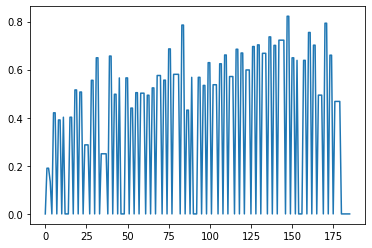

In [21]:
import matplotlib.pyplot as plt
plt.plot(model4_zeros)

In [22]:
model2 = model2.to(device)
        
save_output2 = SaveOutput()
hook_handles2 = []

for layer in model2.modules():
    handle = layer.register_forward_hook(save_output2)
    hook_handles2.append(handle)  

In [23]:
out2 = model2(X)

In [24]:
model2_zeros = []
for layer_output in save_output2.outputs:
    x = torch.flatten(layer_output)
    nonzero = torch.count_nonzero(x).cpu()
    zeros = x.shape[0] - nonzero
    model2_zeros.append(zeros/x.shape[0])

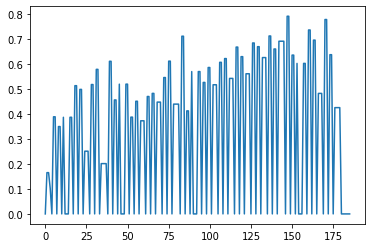

In [25]:
plt.plot(model2_zeros)